In [58]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import sklearn
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
import phate
import hdbscan
import umap
import scprep

import rootutils
project_root = rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)
sys.path.append(os.path.join(project_root, 'src'))

import src.mappings as mappings
from src.train_AE import DenoisingAutoencoder
from src.preprocess import maf_scale
from src.data_loader import load_data_HGDP
from src.metric_clustering import sweep_HDBSCAN, make_confusion_heatmap

from dotenv import load_dotenv
dotenv_path = os.path.join(project_root, '.env')

In [2]:
# Load environment variables
path = load_dotenv(dotenv_path)
PROJECT_PATH = os.getenv('PROJECT_PATH')
SCRATCH_PATH = os.getenv('SCRATCH_PATH')
SAVE_PATH = os.getenv('SAVE_PATH')
Figure_PATH = os.getenv('Figure_PATH')

In [3]:
DATA_PATH = SCRATCH_PATH + 'HGDP+1KGP/V4/'
data_name = 'HGDP'
merged_metadata, relatedness, data, mapping_info = load_data_HGDP(DATA_PATH)
label_pop = merged_metadata['Population']  
label_superpop = merged_metadata['Genetic_region']
cmap_superpop, cmap_pop, order_coarse, order_fine = mapping_info


In [9]:
# normalize data for AE
maf_scaled_data = maf_scale(data)
data_tensor = torch.from_numpy(maf_scaled_data).float()
input_dim = data.shape[1]

# get AE embedding or load from saving

In [28]:
model_save_path = SAVE_PATH + 'AE/ae_trained_model_HGDP_1.pth'

# Initialize the model
latent_dim = 100  # Latent space dimension
model = DenoisingAutoencoder(input_dim=input_dim, latent_dim=latent_dim)

# Load the trained model's weights
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set the model to evaluation mode

# Assuming `data` is your input tensor, move it to the correct device if necessary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data = data_tensor.to(device)  # Move data to device

# Use the encoder for inference (dimensionality reduction)
with torch.no_grad():  # Disable gradient computation for inference
    reduced_data = model.encoder(data)

reduced_data_np = reduced_data.cpu().numpy()
reduced_data_np_norm = reduced_data_np / np.std(reduced_data_np[:, 0])

In [ ]:
# save for next time load
# df = pd.DataFrame(reduced_data_np)
# samples = merged_metadata.index
# df.index = samples
# df.to_csv('/home/mila/s/shuang.ni/phate_genetics/data/HGDP/HGDP_100D_AE_emb.csv')

In [8]:
# can also Load saved latent space
reduced_data = pd.read_csv('/home/mila/s/shuang.ni/phate_genetics/data/HGDP/HGDP_100D_AE_emb.csv', index_col=0)
reduced_data_np = reduced_data.to_numpy() 
reduced_data_np_norm = reduced_data_np / np.std(reduced_data_np[:, 0])

In [9]:
# initial phate embedding
phate_operator_10d = phate.PHATE(random_state=42, 
                                n_components=10, 
                                knn=6, 
                                t=6, 
                                decay=60,
                                n_pca=None)
phate_operator_10d.fit(reduced_data_np_norm)
phate_emb_10d = phate_operator_10d.transform()

Running PHATE on 4150 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 1.88 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 1.92 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.20 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.96 seconds.
Calculated landmark operator in 2.94 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.32 seconds.
Calculating metric MDS...


/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Calculated metric MDS in 146.59 seconds.


In [ ]:
# save the 10D PHATE embeddings
# np.save('/home/mila/s/shuang.ni/phate_genetics/data/HGDP/HGDP_100DAE+10Dphate_emb.npy', phate_emb_10d)

In [ ]:
# load from saving point
phate_emb_10d = np.load('/home/mila/s/shuang.ni/phate_genetics/data/HGDP/HGDP_100DAE+10Dphate_emb.npy')

<Axes: title={'center': 'HGDP superpopulation'}, xlabel='PHATE 1', ylabel='PHATE 2'>

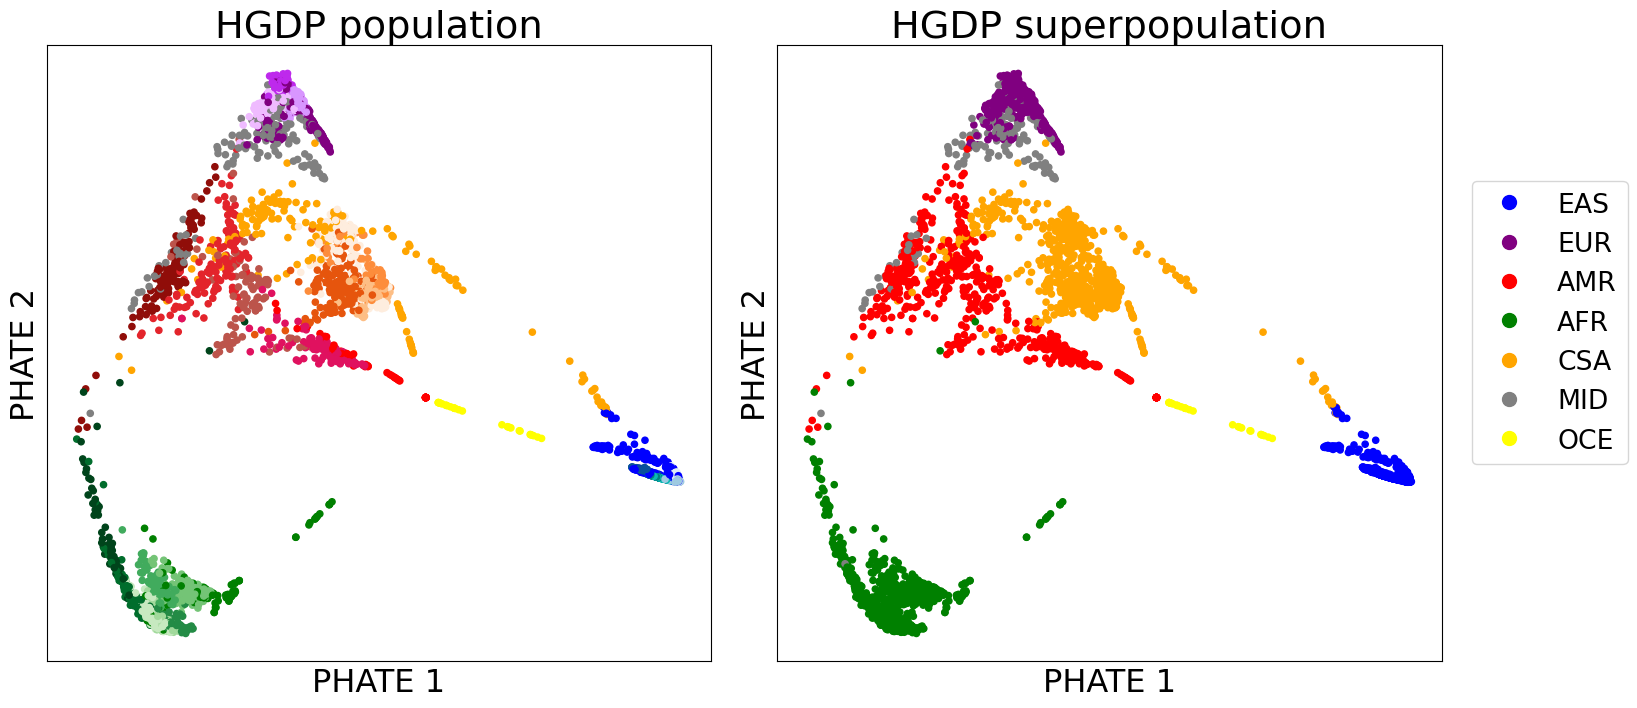

In [17]:
fig, axes = plt.subplots(1,2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1})

scprep.plot.scatter2d(phate_emb_10d, s=20, ax=axes[0],
                      cmap=cmap_pop, c=label_pop,
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ",title= data_name+' population', fontsize=16)
scprep.plot.scatter2d(phate_emb_10d, s=20, ax=axes[1],
                      cmap=cmap_superpop, c=label_superpop,
                      xticks=False, yticks=False, legend=True,
                      legend_loc='right', legend_anchor=(1.3, 0.55), legend_ncol=1,
                      label_prefix="PHATE ",title=data_name+' superpopulation', fontsize=16)

In [25]:
# param_grid = {'min_cluster_size': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#               'min_samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#               'cluster_selection_epsilon': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
param_grid = {'min_cluster_size': [5, 10],
            #   'min_samples': [1, 5],
              'cluster_selection_epsilon': [1.0, 1.5]}
# hdbscan parameters
static_params = {'cluster_selection_method':'leaf', 'metric':'euclidean', 'min_samples':1}

best_result, average_result = sweep_HDBSCAN(phate_emb_10d, label_pop, param_grid, **static_params)

In [27]:
# hdbscan parameters
min_cluster_size = 60 # 25
min_samples = 1
eps = 3.5
metric='euclidean'
alpha = 1.5
cluster_selection_method='leaf'
# use hdbscan package
clusterer_phate = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                            min_samples=min_samples, 
                            # alpha = alpha, # doesn't matter
                            # cluster_selection_epsilon=eps, 
                            # metric = metric, 
                            cluster_selection_method = cluster_selection_method
)
cluster_labels = clusterer_phate.fit(phate_emb_10d)
print('Number of clusters:', str(max(clusterer_phate.labels_)))
print('Number unassigned:', str(np.sum(clusterer_phate.labels_ == -1)))
cluster_label, counts = np.unique(clusterer_phate.labels_, return_counts=True)
print(f'Cluster counts: {counts}')

Number of clusters: 18
Number unassigned: 1035
Cluster counts: [1035  133   73  119   67  195   96  131  149  111   76  230  230  134
  332   70  350  419  125   75]


In [ ]:
best_params = best_result["best_params"]
clusterer = hdbscan.HDBSCAN(**best_params)

{'best_params': {'min_cluster_size': 5,
  'min_samples': 1,
  'cluster_selection_epsilon': 1.0},
 'best_ari': 0.0013148936705942736,
 'best_clusters': array([1, 1, 1, ..., 1, 1, 1])}

# PHATE clustering

In [ ]:
phate_clusters_fine = phate.cluster.kmeans(phate_operator_10d, n_clusters=78, max_clusters=80, random_state=42)

/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


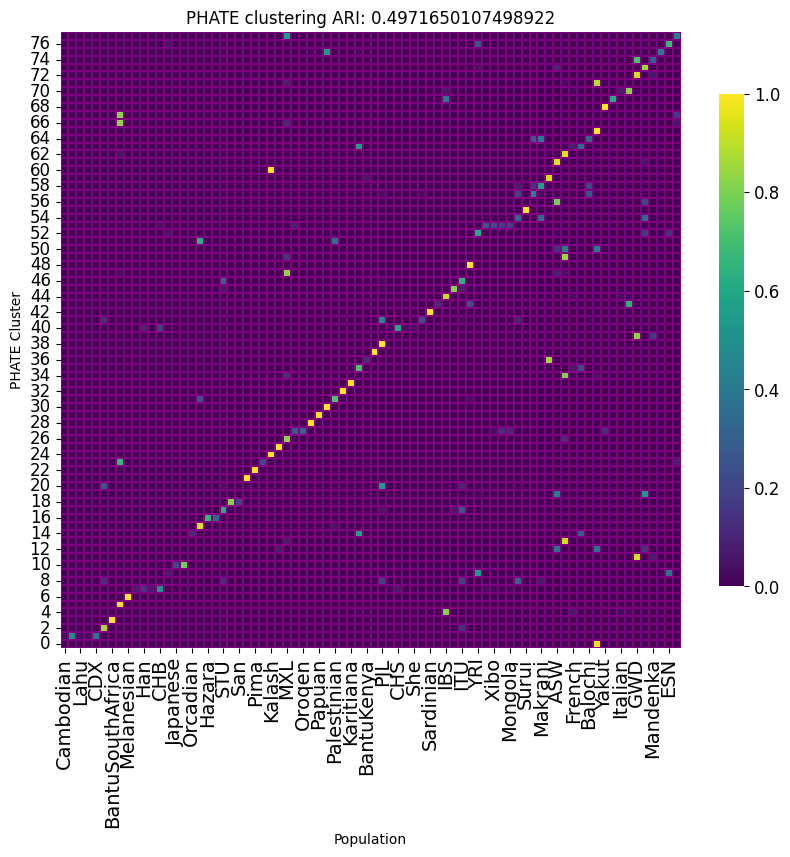

In [ ]:
ari = adjusted_rand_score(label_pop.values, phate_clusters_fine)
heatmap = make_confusion_heatmap(label_pop.values, phate_clusters_fine, ax=None, colorbar=True, method = 'PHATE')
heatmap.set_title('PHATE clustering ARI: ' + str(ari))
plt.show()

In [22]:
phate_clusters_coarse = phate.cluster.kmeans(phate_operator_10d, n_clusters=7, max_clusters=10, random_state=42)

/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


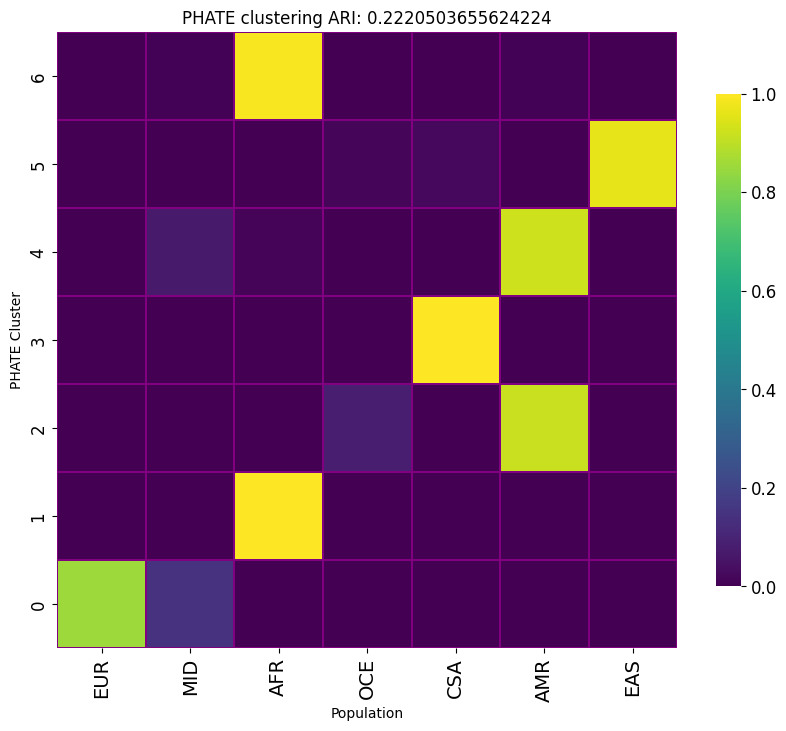

In [23]:
ari = adjusted_rand_score(label_pop.values, phate_clusters_coarse)
heatmap = make_confusion_heatmap(label_superpop.values, phate_clusters_coarse, ax=None, colorbar=True, method = 'PHATE')
heatmap.set_title('PHATE clustering ARI: ' + str(ari))
plt.show()

# UMAP

In [6]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(data)

In [7]:
umap_op = umap.UMAP(n_components=10, random_state=42)
umap_embedding = umap_op.fit_transform(pca_input)

/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## HDBSCAN

In [55]:
param_grid = {'min_cluster_size': [5, 10,30,60, 90],
            #   'min_samples': [1, 5],
            #   'cluster_selection_epsilon': [0.5, 1.0, 1.5, 2.0]
            }
# hdbscan parameters
static_params = {
                # 'cluster_selection_method':'leaf', 
                 'metric':'euclidean', 
                 'min_samples':1
                 }

best_result, average_result = sweep_HDBSCAN(umap_embedding, label_pop, param_grid, **static_params)
best_result

{'best_params': {'min_cluster_size': 10},
 'best_ari': 0.604862064680195,
 'best_clusters': array([18, 18, 18, ..., 12, 16, 26])}

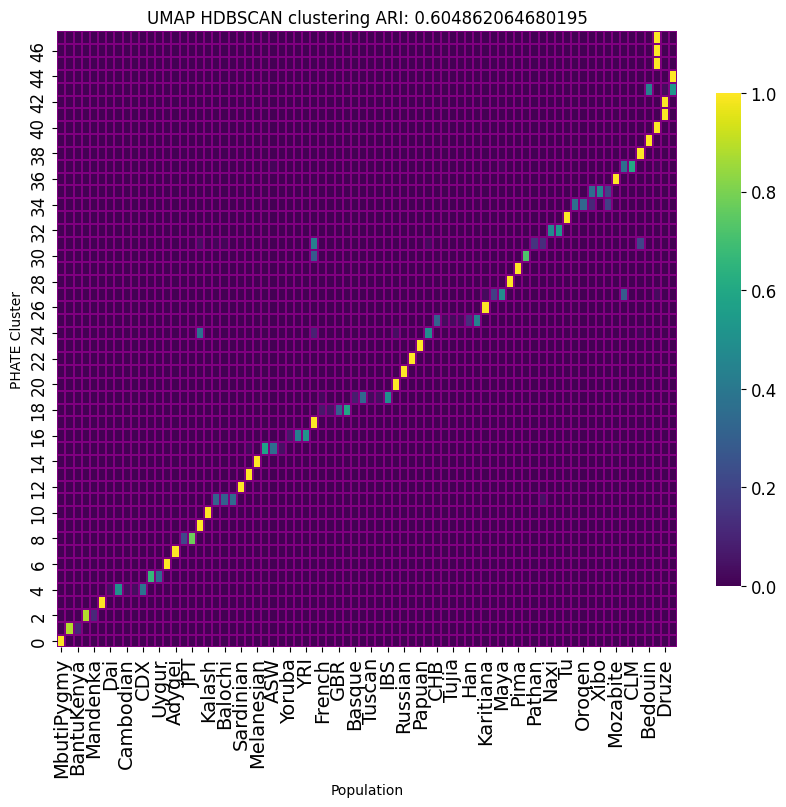

In [56]:
best_params = best_result["best_params"]
clusterer_params = {**best_params, **static_params}
UMAP_HDBSCAN_clusterer = hdbscan.HDBSCAN(**clusterer_params)
HDBSCAN_cluster_labels = UMAP_HDBSCAN_clusterer.fit_predict(umap_embedding)

ari = adjusted_rand_score(label_pop.values, HDBSCAN_cluster_labels)
heatmap = make_confusion_heatmap(label_pop.values, HDBSCAN_cluster_labels, ax=None, colorbar=True, method = 'PHATE')
heatmap.set_title('UMAP HDBSCAN clustering ARI: ' + str(ari))
plt.show()


## kmeans

In [ ]:
k = 78  # Specify the number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmenas_cluster_labels = kmeans.fit_predict(umap_embedding)

/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


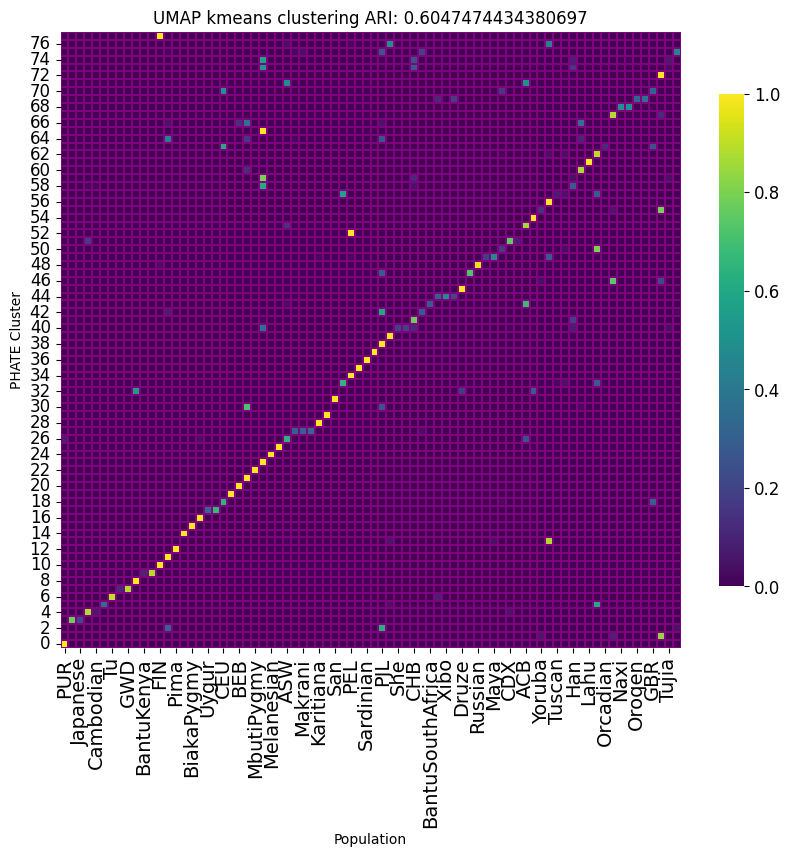

In [38]:
ari = adjusted_rand_score(label_pop.values, kmenas_cluster_labels)
heatmap = make_confusion_heatmap(label_pop.values, kmenas_cluster_labels, ax=None, colorbar=True, method = 'PHATE')
heatmap.set_title('UMAP kmeans clustering ARI: ' + str(ari))
plt.show()